In [ ]:
from langgraph.graph import StateGraph, START, END 
from langchain_openai import ChatOpenAI 
from typing import TypedDict, Dict, Literal, Annotated
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from dotenv import load_dotenv
import operator 
load_dotenv()

True

In [4]:
generator_llm = ChatOpenAI(model = "gpt-4o")
evaluator_llm = ChatOpenAI(model = "gpt-4o-mini")
optimizer_llm = ChatOpenAI(model = "gpt-4o")

In [11]:
from pydantic import BaseModel, Field
class TweetEvaluation(BaseModel):
    evaluation: Literal["approval", "needs_improvement"] = Field(description="Final evaluation result")
    feedback: str = Field(..., description="Feedback for the tweet")

structured_output_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [29]:
# Graph State
class TweetState(TypedDict):
    topic: str
    tweet: str 
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int 
    max_iter: int 

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [30]:
def generate_tweet(state: TweetState):
    # Prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
    # Send generator llm 
    response = generator_llm.invoke(messages).content

    return {'tweet': response, 'tweet_history': [response]}

In [31]:
def evaluate_tweet(state: TweetState):
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]          

    response = structured_output_llm.invoke(messages)

    return {'evaluation': response.evaluation, 'feedback': response.feedback, "feedback_history": [response.feedback]} 

In [32]:
def optimize_tweet(state: TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content

    iteration = state["iteration"] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [33]:
def route_evaluation(state: TweetState):
    if state["evaluation"] == "approved" or state["iteration"] > state["max_iter"]:
        return "approved"
    else:
        return "needs_improvement"

In [34]:
graph = StateGraph(TweetState)

graph.add_node("generate", generate_tweet)
graph.add_node("evaluate", evaluate_tweet)
graph.add_node("optimizer", optimize_tweet)

graph.add_edge(START, "generate")
graph.add_edge("generate", "evaluate")

graph.add_conditional_edges("evaluate", route_evaluation, {"approved": END, "needs_improvement": "optimizer"})
graph.add_edge("optimizer", "evaluate")

workflow = graph.compile()

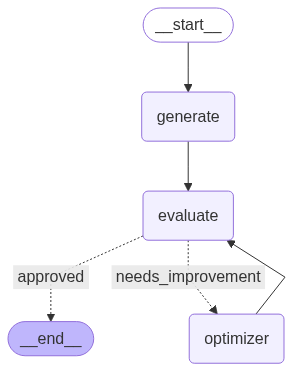

In [35]:
workflow

In [37]:
initial_state = {
    'topic': "Aritificial Intelligence", 
    "iteration": 1, 
    "max_iter": 5
}

result = workflow.invoke(initial_state)

In [39]:
result

{'topic': 'Aritificial Intelligence',
 'tweet': "Got dumped by my AI toaster—it ran off with an espresso machine. Guess I can't compete with a relationship that's perfectly brewed! ☕🤖 #RoastedRomance #EspressYoSelf",
 'evaluation': 'approval',
 'feedback': 'This tweet displays a commendable level of originality with its playful concept of an AI toaster and an espresso machine forming a relationship, which is a fresh take on technology and romance. The humor is light-hearted and clever, providing a chuckle without resorting to clichés. It effectively uses punchy phrasing that captures attention and fits well within the character limit. The use of hashtags enhances virality potential by targeting audiences interested in humor about relationships and coffee. Overall, the format is perfect, making it a strong tweet.',
 'iteration': 6,
 'max_iter': 5,
 'tweet_history': ['Tried to have a deep conversation with AI today. Ended up with my toaster suggesting I watch the Terminator movies for "s